# Extended Error Analysis for TabICL and TabPFN

This notebook extends the error analysis from the comprehensive comparison to include detailed analysis of TabICL and TabPFN models. It builds upon the comprehensive comparison notebook and assumes the following variables are available:

- **Models**: `models` dictionary containing XGBoost, TabPFN v2, and TabICL
- **Data**: `X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`
- **Features**: `feature_names` list

## Analysis Components:
1. **Cross-Model Error Comparison**: Compare error patterns across all models
2. **Model-Specific Error Analysis**: Deep dive into TabICL and TabPFN errors
3. **Confidence Analysis**: Prediction confidence comparison
4. **Feature-based Error Analysis**: Which features cause errors in each model
5. **Error Overlap Analysis**: Common vs unique errors across models
6. **Uncertainty Quantification**: Model uncertainty in predictions

In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
# Memory management utilities
import gc
import pickle
import os
import torch

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Extended Error Analysis Framework Loaded")
print("Ready to analyze TabICL and TabPFN error patterns")

📊 Extended Error Analysis Framework Loaded
Ready to analyze TabICL and TabPFN error patterns


In [8]:
# Load trained models and results from Section 2
try:
    with open('./online_shoppers_section2_results.pkl', 'rb') as f:
        section2_data = pickle.load(f)

    # Extract variables
    models = section2_data['models']
    evaluator = section2_data['evaluator']
    X_train_scaled = section2_data['X_train_scaled']
    X_val_scaled = section2_data['X_val_scaled']
    X_test_scaled = section2_data['X_test_scaled']
    y_train = section2_data['y_train']
    y_val = section2_data['y_val']
    y_test = section2_data['y_test']
    feature_names = section2_data['feature_names']
    month_mapping = section2_data['month_mapping']
    visitor_mapping = section2_data['visitor_mapping']
    class_names = section2_data['class_names']
    label_encoder_month = section2_data['label_encoder_month']
    label_encoder_visitor = section2_data['label_encoder_visitor']
    scaler = section2_data['scaler']
    data_summary = section2_data['data_summary']
    comparison_df = section2_data['comparison_df']

    print("✅ Section 2 results loaded successfully!")
    print(f"Models available: {list(models.keys())}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {len(class_names)}")
    print(f"Test samples: {len(X_test_scaled):,}")
    
    # Display feature names for reference
    print(f"\n📋 Feature Names:")
    for i, feature in enumerate(feature_names):
        print(f"   {i+1:2d}. {feature}")

except FileNotFoundError:
    print("❌ Section 2 results not found!")
    print("Please run Section 2 (Model Training) notebook first.")
    raise

# Verify required variables from comprehensive comparison notebook
required_vars = [
    'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test', 
    'feature_names', 'models'
]

print("🔍 Verifying Required Resources:")
for var_name in required_vars:
    if var_name in globals():
        if var_name == 'models':
            print(f"   ✅ {var_name}: {list(models.keys())}")
        elif var_name in ['X_train_scaled', 'X_test_scaled']:
            print(f"   ✅ {var_name}: shape {globals()[var_name].shape}")
        elif var_name in ['y_train', 'y_test']:
            print(f"   ✅ {var_name}: length {len(globals()[var_name])}")
        elif var_name == 'feature_names':
            print(f"   ✅ {var_name}: {len(feature_names)} features")
        else:
            print(f"   ✅ {var_name}: available")
    else:
        print(f"   ❌ {var_name}: NOT FOUND - Please run comprehensive comparison notebook first")

# Define model names for analysis
model_names = list(models.keys())
print(f"\n📊 Models available for error analysis: {model_names}")
fttransformer_model = models['FT-Transformer']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ft_wrapper = evaluator.create_pytorch_wrapper(
            model=fttransformer_model,
            device=device,
            batch_size=256
)
models['FT-Transformer'] = ft_wrapper
model_to_analyze = ft_wrapper
model_name = "FT-Transformer"

✅ Section 2 results loaded successfully!
Models available: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']
Features: 17
Classes: 2
Test samples: 2,466

📋 Feature Names:
    1. Administrative
    2. Administrative_Duration
    3. Informational
    4. Informational_Duration
    5. ProductRelated
    6. ProductRelated_Duration
    7. BounceRates
    8. ExitRates
    9. PageValues
   10. SpecialDay
   11. Month
   12. OperatingSystems
   13. Browser
   14. Region
   15. TrafficType
   16. VisitorType
   17. Weekend
🔍 Verifying Required Resources:
   ✅ X_train_scaled: shape (7891, 17)
   ✅ X_test_scaled: shape (2466, 17)
   ✅ y_train: length 7891
   ✅ y_test: length 2466
   ✅ feature_names: 17 features
   ✅ models: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']

📊 Models available for error analysis: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']


## 1. Cross-Model Error Comparison

First, let's get predictions from all models and compare their error patterns.

In [9]:
# Get predictions and probabilities from all models
predictions = {}
probabilities = {}
misclassified_indices = {}

print("🔮 Generating predictions from all models...")

for model_name, model in models.items():
    print(f"   Processing {model_name}...")
    
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    predictions[model_name] = y_pred
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        probabilities[model_name] = y_proba
    else:
        probabilities[model_name] = None
    
    # Find misclassified samples
    misclassified_mask = (y_pred != y_test)
    misclassified_indices[model_name] = np.where(misclassified_mask)[0]
    
    print(f"     Misclassified: {len(misclassified_indices[model_name])} / {len(y_test)} "
          f"({len(misclassified_indices[model_name])/len(y_test)*100:.2f}%)")

print("\n✅ Predictions generated for all models")

🔮 Generating predictions from all models...
   Processing XGBoost...
     Misclassified: 253 / 2466 (10.26%)
   Processing TabPFN v2...
     Misclassified: 244 / 2466 (9.89%)
   Processing TabICL...
     Misclassified: 248 / 2466 (10.06%)
   Processing FT-Transformer...
     Misclassified: 257 / 2466 (10.42%)

✅ Predictions generated for all models


In [10]:
# Create comprehensive error comparison table
error_comparison = []

for model_name in model_names:
    y_pred = predictions[model_name]
    
    # Calculate detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    error_comparison.append({
        'Model': model_name,
        'Total_Errors': len(misclassified_indices[model_name]),
        'Error_Rate_%': len(misclassified_indices[model_name])/len(y_test)*100,
        'False_Positives': fp,
        'False_Negatives': fn,
        'FP_Rate_%': fp/(fp+tn)*100,
        'FN_Rate_%': fn/(fn+tp)*100,
        'Precision_Class_0': precision[0],
        'Precision_Class_1': precision[1],
        'Recall_Class_0': recall[0],
        'Recall_Class_1': recall[1],
        'F1_Class_0': f1[0],
        'F1_Class_1': f1[1]
    })

error_df = pd.DataFrame(error_comparison)

print("📊 CROSS-MODEL ERROR COMPARISON")
print("=" * 80)
print(error_df.round(4).to_string(index=False))

# Save results
error_df.to_csv('cross_model_error_comparison.csv', index=False)
print("\n💾 Results saved to 'cross_model_error_comparison.csv'")

📊 CROSS-MODEL ERROR COMPARISON
         Model  Total_Errors  Error_Rate_%  False_Positives  False_Negatives  FP_Rate_%  FN_Rate_%  Precision_Class_0  Precision_Class_1  Recall_Class_0  Recall_Class_1  F1_Class_0  F1_Class_1
       XGBoost           253       10.2595               87              166     4.1747    43.4555             0.9233             0.7129          0.9583          0.5654      0.9404      0.6307
     TabPFN v2           244        9.8946               88              156     4.2226    40.8377             0.9275             0.7197          0.9578          0.5916      0.9424      0.6494
        TabICL           248       10.0568               89              159     4.2706    41.6230             0.9262             0.7147          0.9573          0.5838      0.9415      0.6427
FT-Transformer           257       10.4217              110              147     5.2783    38.4817             0.9307             0.6812          0.9472          0.6152      0.9389      0.6465

💾 R

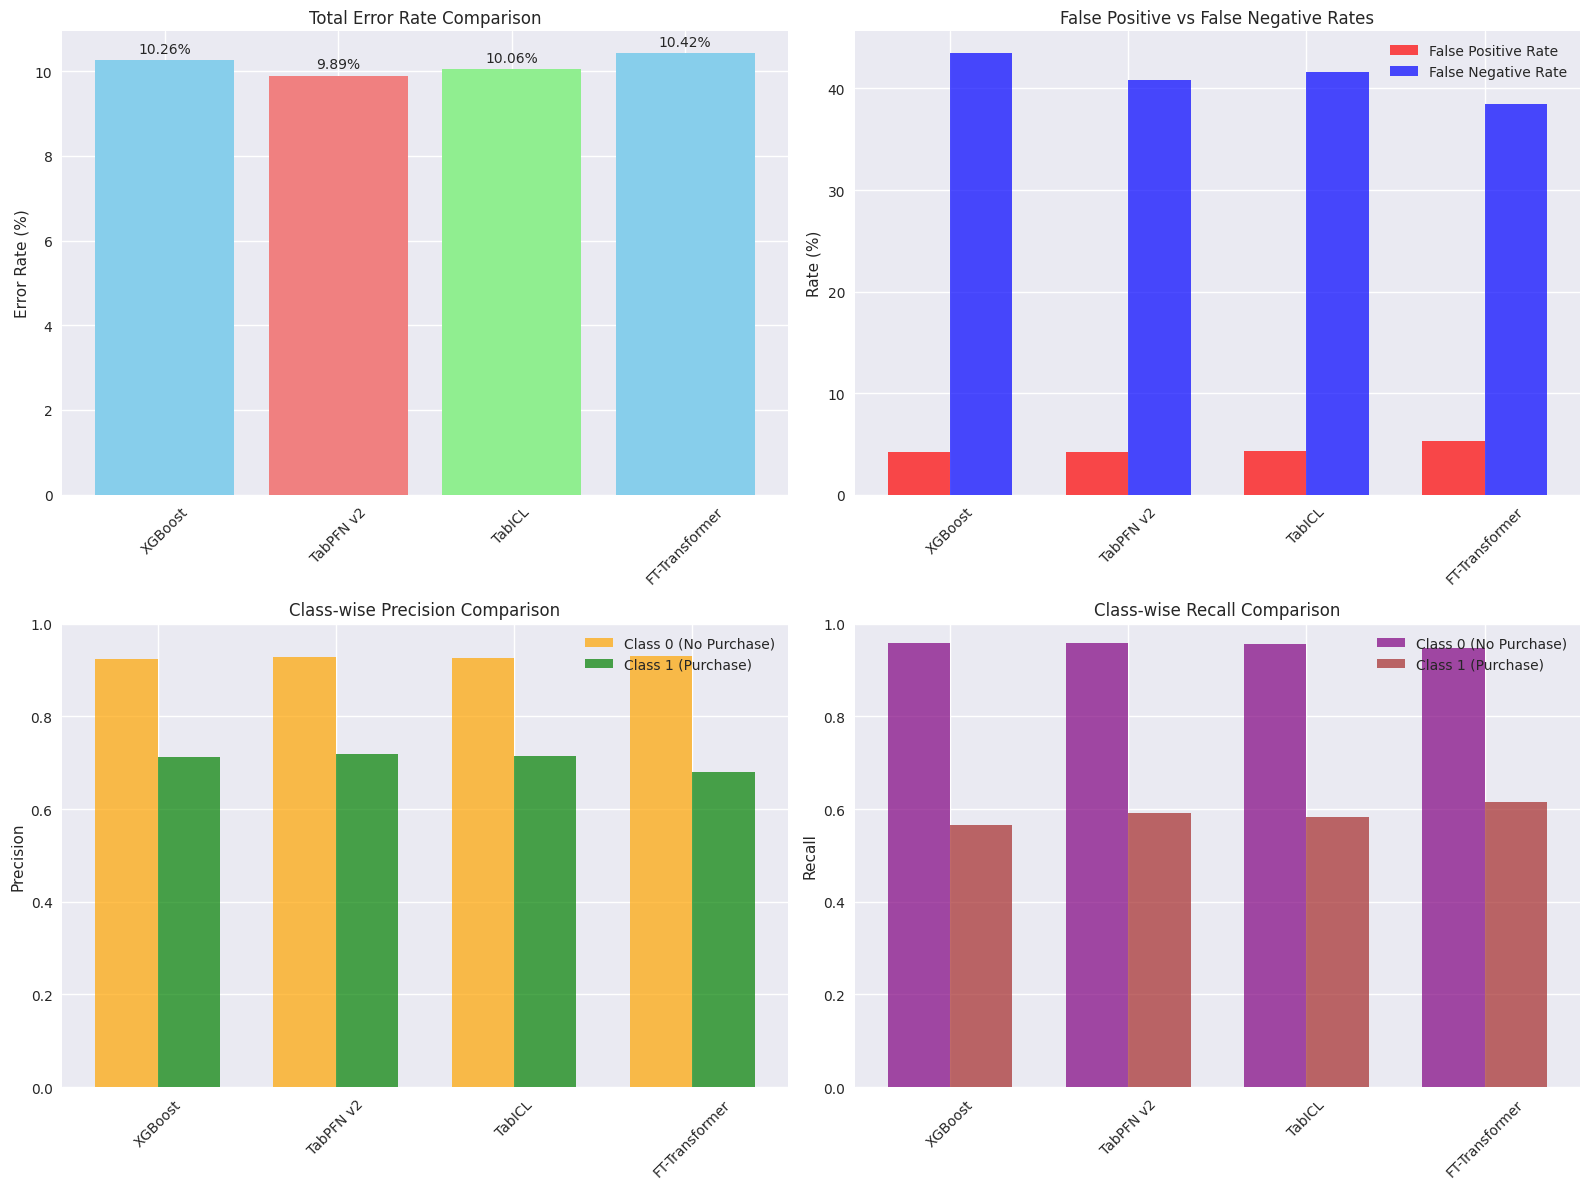

In [11]:
# Visualize error comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total Error Rate Comparison
ax1.bar(error_df['Model'], error_df['Error_Rate_%'], 
        color=['skyblue', 'lightcoral', 'lightgreen'][:len(model_names)])
ax1.set_title('Total Error Rate Comparison')
ax1.set_ylabel('Error Rate (%)')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(error_df['Error_Rate_%']):
    ax1.text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# 2. False Positive vs False Negative Rates
x = np.arange(len(model_names))
width = 0.35

ax2.bar(x - width/2, error_df['FP_Rate_%'], width, label='False Positive Rate', color='red', alpha=0.7)
ax2.bar(x + width/2, error_df['FN_Rate_%'], width, label='False Negative Rate', color='blue', alpha=0.7)
ax2.set_title('False Positive vs False Negative Rates')
ax2.set_ylabel('Rate (%)')
ax2.set_xticks(x)
ax2.set_xticklabels(error_df['Model'], rotation=45)
ax2.legend()

# 3. Class-wise Precision Comparison
ax3.bar(x - width/2, error_df['Precision_Class_0'], width, label='Class 0 (No Purchase)', color='orange', alpha=0.7)
ax3.bar(x + width/2, error_df['Precision_Class_1'], width, label='Class 1 (Purchase)', color='green', alpha=0.7)
ax3.set_title('Class-wise Precision Comparison')
ax3.set_ylabel('Precision')
ax3.set_xticks(x)
ax3.set_xticklabels(error_df['Model'], rotation=45)
ax3.legend()
ax3.set_ylim(0, 1)

# 4. Class-wise Recall Comparison
ax4.bar(x - width/2, error_df['Recall_Class_0'], width, label='Class 0 (No Purchase)', color='purple', alpha=0.7)
ax4.bar(x + width/2, error_df['Recall_Class_1'], width, label='Class 1 (Purchase)', color='brown', alpha=0.7)
ax4.set_title('Class-wise Recall Comparison')
ax4.set_ylabel('Recall')
ax4.set_xticks(x)
ax4.set_xticklabels(error_df['Model'], rotation=45)
ax4.legend()
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('cross_model_error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Model-Specific Confidence Analysis

Analyze prediction confidence for each model to understand uncertainty patterns.

🎯 CONFIDENCE ANALYSIS

XGBoost Confidence Analysis:
   Average confidence (correct): 0.9398
   Average confidence (misclassified): 0.7673
   Low confidence errors (<60%): 17.0%

TabPFN v2 Confidence Analysis:
   Average confidence (correct): 0.9357
   Average confidence (misclassified): 0.7371
   Low confidence errors (<60%): 27.5%

TabICL Confidence Analysis:
   Average confidence (correct): 0.9348
   Average confidence (misclassified): 0.7240
   Low confidence errors (<60%): 28.2%

FT-Transformer Confidence Analysis:
   Average confidence (correct): 0.9367
   Average confidence (misclassified): 0.7428
   Low confidence errors (<60%): 24.1%


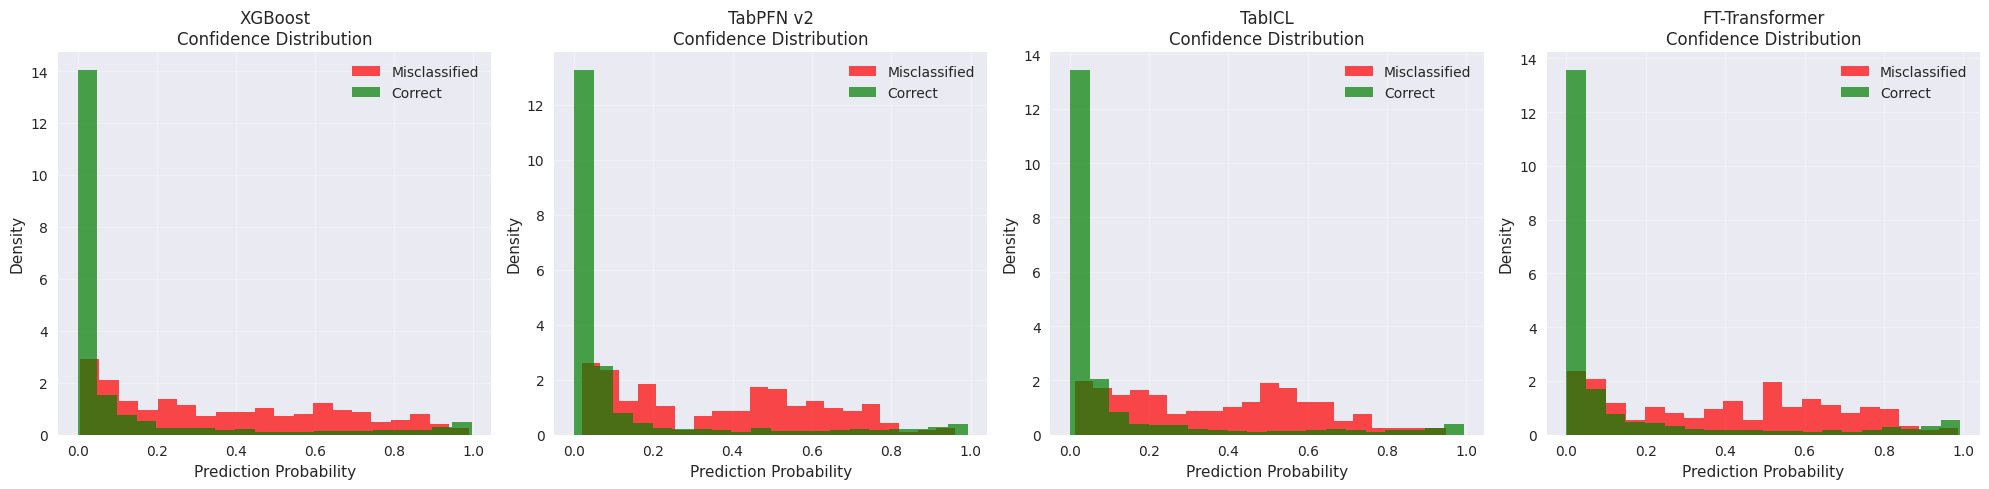


📊 CONFIDENCE STATISTICS
         Model  Avg_Confidence_Correct  Avg_Confidence_Misclassified  Std_Confidence_Correct  Std_Confidence_Misclassified  Low_Confidence_Errors_%
       XGBoost                  0.9398                        0.7673                  0.1050                        0.1489                  16.9960
     TabPFN v2                  0.9357                        0.7371                  0.1073                        0.1531                  27.4590
        TabICL                  0.9348                        0.7240                  0.1102                        0.1500                  28.2258
FT-Transformer                  0.9367                        0.7428                  0.1083                        0.1532                  24.1245


In [12]:
# Confidence analysis for each model
print("🎯 CONFIDENCE ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
if len(model_names) == 1:
    axes = [axes]

confidence_stats = []

for i, model_name in enumerate(model_names):
    if probabilities[model_name] is not None:
        y_proba = probabilities[model_name]
        misclassified_mask = (predictions[model_name] != y_test)
        
        misclassified_proba = y_proba[misclassified_mask]
        correct_proba = y_proba[~misclassified_mask]
        
        # Plot confidence distributions
        axes[i].hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', 
                    color='red', density=True)
        axes[i].hist(correct_proba, bins=20, alpha=0.7, label='Correct', 
                    color='green', density=True)
        axes[i].set_xlabel('Prediction Probability')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'{model_name}\nConfidence Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Calculate confidence statistics
        confidence_stats.append({
            'Model': model_name,
            'Avg_Confidence_Correct': np.mean(np.maximum(correct_proba, 1-correct_proba)),
            'Avg_Confidence_Misclassified': np.mean(np.maximum(misclassified_proba, 1-misclassified_proba)),
            'Std_Confidence_Correct': np.std(np.maximum(correct_proba, 1-correct_proba)),
            'Std_Confidence_Misclassified': np.std(np.maximum(misclassified_proba, 1-misclassified_proba)),
            'Low_Confidence_Errors_%': np.mean(np.maximum(misclassified_proba, 1-misclassified_proba) < 0.6) * 100
        })
        
        print(f"\n{model_name} Confidence Analysis:")
        print(f"   Average confidence (correct): {confidence_stats[-1]['Avg_Confidence_Correct']:.4f}")
        print(f"   Average confidence (misclassified): {confidence_stats[-1]['Avg_Confidence_Misclassified']:.4f}")
        print(f"   Low confidence errors (<60%): {confidence_stats[-1]['Low_Confidence_Errors_%']:.1f}%")
    else:
        axes[i].text(0.5, 0.5, f'{model_name}\nNo probability\navailable', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{model_name}\nConfidence Distribution')

plt.tight_layout()
plt.savefig('model_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Create confidence statistics table
if confidence_stats:
    confidence_df = pd.DataFrame(confidence_stats)
    print("\n📊 CONFIDENCE STATISTICS")
    print(confidence_df.round(4).to_string(index=False))
    confidence_df.to_csv('model_confidence_statistics.csv', index=False)

## 3. Feature-based Error Analysis

Analyze which features are most associated with errors in each model.

In [13]:
# Feature-based error analysis for each model
print("🔍 FEATURE-BASED ERROR ANALYSIS")
print("=" * 60)

feature_error_analysis = {}

for model_name in model_names:
    print(f"\nAnalyzing {model_name}...")
    
    misclassified_mask = (predictions[model_name] != y_test)
    
    if np.sum(misclassified_mask) > 0:
        misclassified_features = X_test_scaled[misclassified_mask]
        correct_features = X_test_scaled[~misclassified_mask]
        
        # Calculate feature differences
        feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
        feature_std_diff = np.std(misclassified_features, axis=0) - np.std(correct_features, axis=0)
        
        # Statistical significance test (t-test)
        from scipy.stats import ttest_ind
        p_values = []
        for i in range(len(feature_names)):
            _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
            p_values.append(p_val)
        
        feature_error_analysis[model_name] = {
            'feature_diff': feature_diff,
            'feature_std_diff': feature_std_diff,
            'p_values': np.array(p_values),
            'significant_features': np.array(p_values) < 0.05
        }
        
        # Print top features with significant differences
        significant_indices = np.where(np.array(p_values) < 0.05)[0]
        if len(significant_indices) > 0:
            sorted_sig_indices = significant_indices[np.argsort(np.abs(feature_diff[significant_indices]))[::-1]]
            
            print(f"   Top 5 significant features (p < 0.05):")
            for i, idx in enumerate(sorted_sig_indices[:5]):
                print(f"     {i+1}. {feature_names[idx]}: diff={feature_diff[idx]:.4f}, p={p_values[idx]:.4f}")
        else:
            print(f"   No statistically significant feature differences found")
    else:
        print(f"   No misclassified samples for {model_name}")
        feature_error_analysis[model_name] = None

🔍 FEATURE-BASED ERROR ANALYSIS

Analyzing XGBoost...
   Top 5 significant features (p < 0.05):
     1. ProductRelated: diff=0.6888, p=0.0000
     2. ProductRelated_Duration: diff=0.6073, p=0.0000
     3. Administrative: diff=0.5784, p=0.0000
     4. PageValues: diff=0.4411, p=0.0000
     5. Administrative_Duration: diff=0.4041, p=0.0000

Analyzing TabPFN v2...
   Top 5 significant features (p < 0.05):
     1. ProductRelated: diff=0.5894, p=0.0000
     2. PageValues: diff=0.5401, p=0.0000
     3. ProductRelated_Duration: diff=0.4982, p=0.0000
     4. Administrative: diff=0.4957, p=0.0000
     5. ExitRates: diff=-0.3465, p=0.0000

Analyzing TabICL...
   Top 5 significant features (p < 0.05):
     1. ProductRelated: diff=0.6469, p=0.0000
     2. Administrative: diff=0.5584, p=0.0000
     3. PageValues: diff=0.5528, p=0.0000
     4. ProductRelated_Duration: diff=0.5506, p=0.0000
     5. Administrative_Duration: diff=0.3977, p=0.0000

Analyzing FT-Transformer...
   Top 5 significant feature

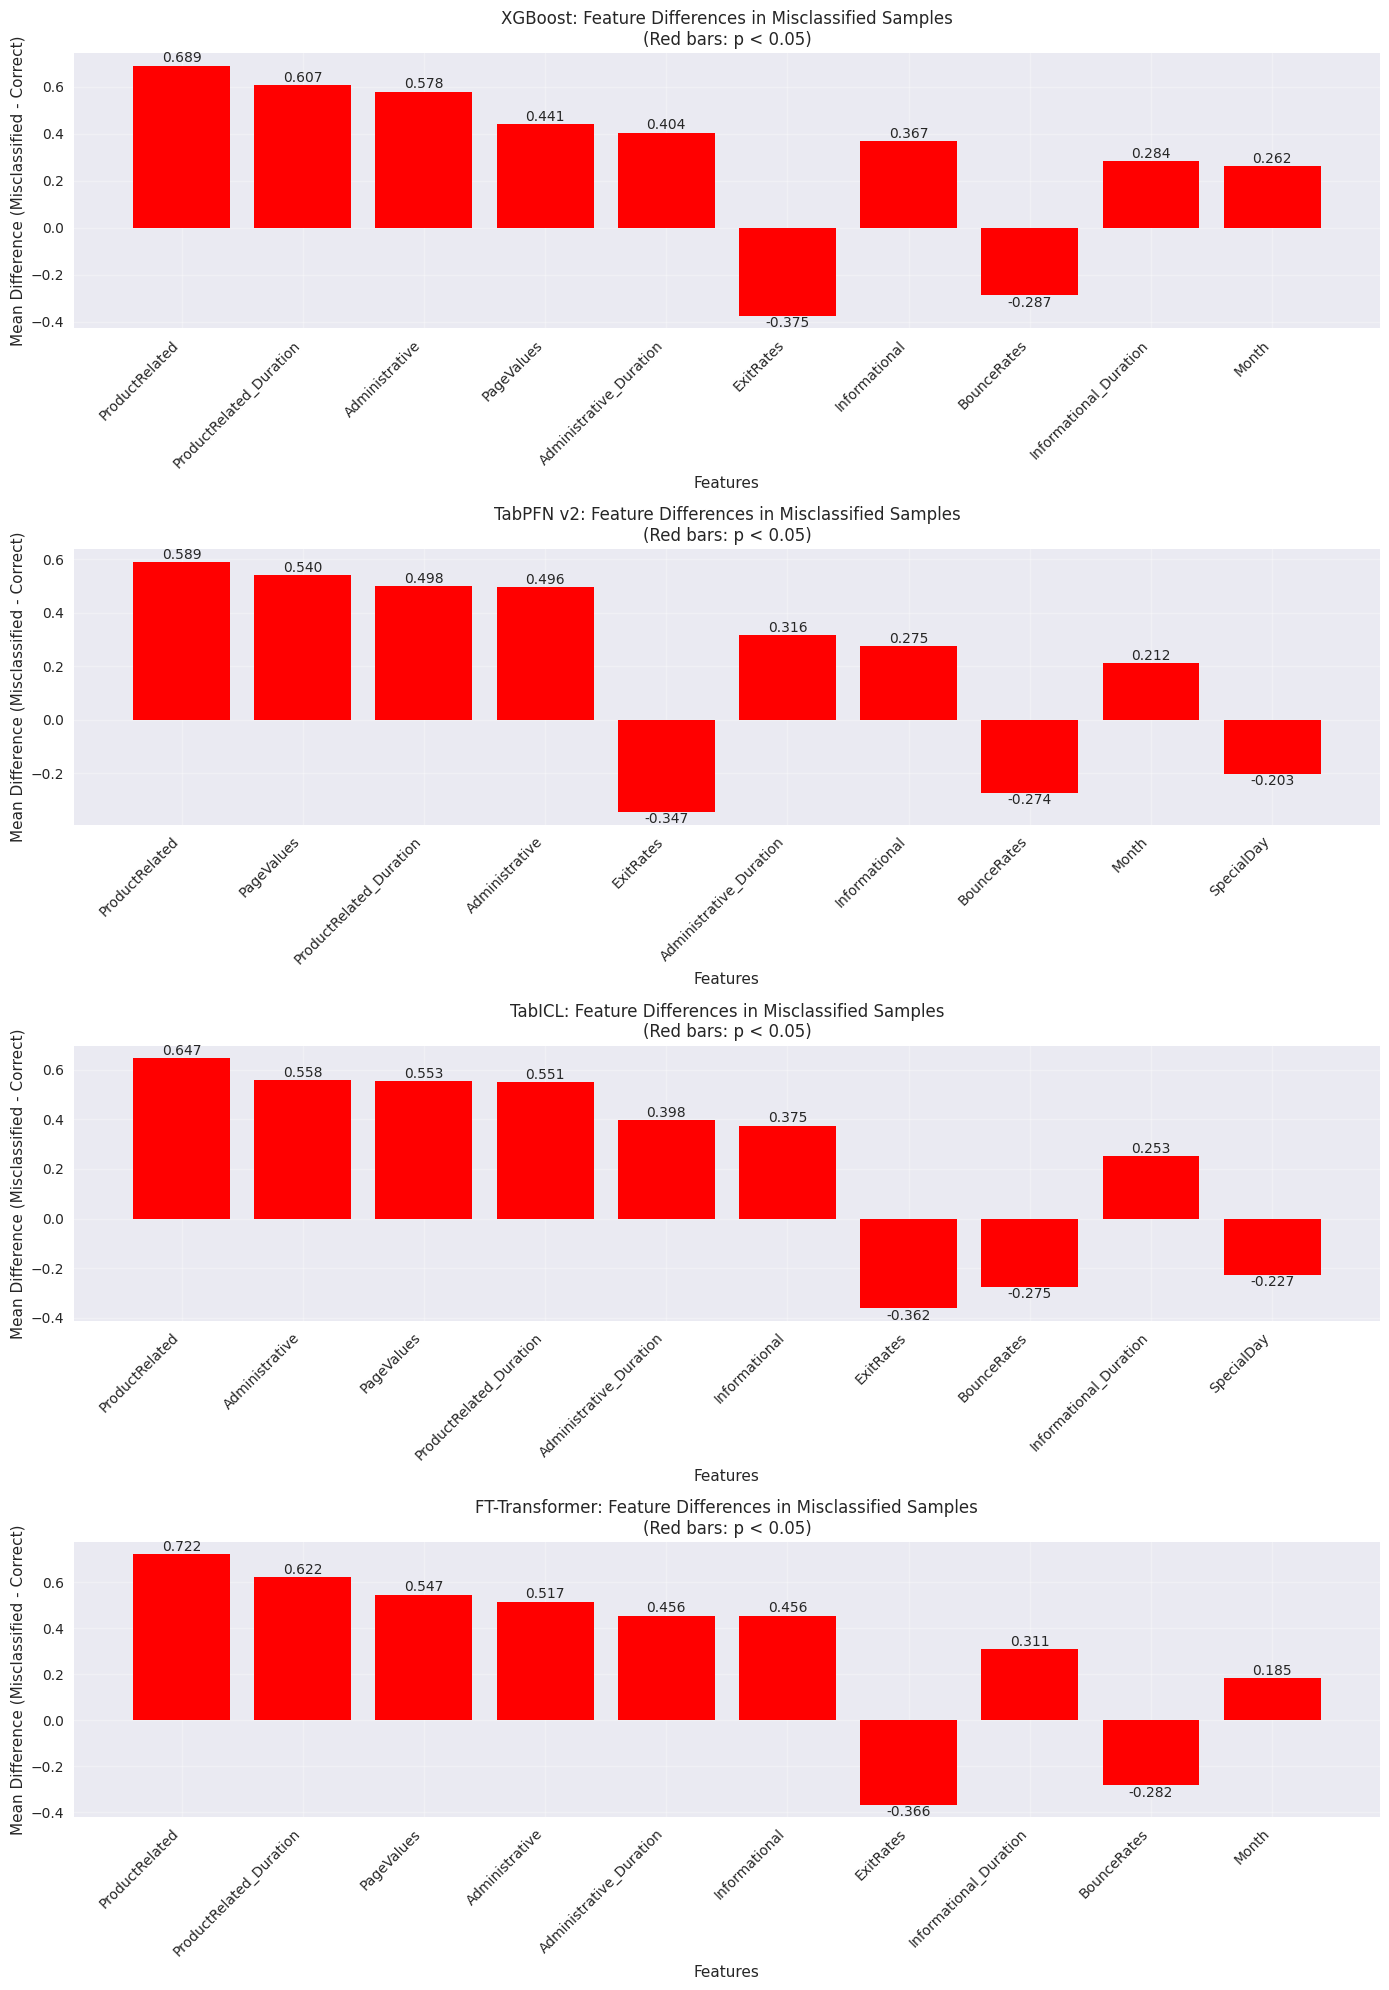

In [14]:
# Visualize feature differences across models
n_models = len([m for m in model_names if feature_error_analysis[m] is not None])
if n_models > 0:
    fig, axes = plt.subplots(n_models, 1, figsize=(14, 5*n_models))
    if n_models == 1:
        axes = [axes]
    
    plot_idx = 0
    for model_name in model_names:
        if feature_error_analysis[model_name] is not None:
            feature_diff = feature_error_analysis[model_name]['feature_diff']
            p_values = feature_error_analysis[model_name]['p_values']
            
            # Sort features by absolute difference
            sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]
            
            # Create bar plot
            bars = axes[plot_idx].bar(range(10), feature_diff[sorted_indices], 
                                     color=['red' if p_values[i] < 0.05 else 'lightblue' 
                                           for i in sorted_indices])
            
            axes[plot_idx].set_xlabel('Features')
            axes[plot_idx].set_ylabel('Mean Difference (Misclassified - Correct)')
            axes[plot_idx].set_title(f'{model_name}: Feature Differences in Misclassified Samples\n(Red bars: p < 0.05)')
            axes[plot_idx].set_xticks(range(10))
            axes[plot_idx].set_xticklabels([feature_names[i] for i in sorted_indices], rotation=45, ha='right')
            axes[plot_idx].grid(True, alpha=0.3)
            
            # Add value labels
            for i, (bar, idx) in enumerate(zip(bars, sorted_indices)):
                height = bar.get_height()
                axes[plot_idx].text(bar.get_x() + bar.get_width()/2., height + np.sign(height)*0.001,
                                   f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.savefig('feature_error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Error Overlap Analysis

Analyze which samples are commonly misclassified across models vs model-specific errors.

In [15]:
# Error overlap analysis
print("🔄 ERROR OVERLAP ANALYSIS")
print("=" * 60)

# Create error matrix (samples x models)
error_matrix = np.zeros((len(y_test), len(model_names)), dtype=bool)

for i, model_name in enumerate(model_names):
    misclassified_mask = (predictions[model_name] != y_test)
    error_matrix[:, i] = misclassified_mask

# Analyze overlap patterns
overlap_analysis = {}

# Common errors (misclassified by all models)
common_errors = np.all(error_matrix, axis=1)
overlap_analysis['common_errors'] = np.sum(common_errors)

# Model-specific errors
for i, model_name in enumerate(model_names):
    # Errors unique to this model
    other_models_correct = ~np.any(error_matrix[:, [j for j in range(len(model_names)) if j != i]], axis=1)
    unique_errors = error_matrix[:, i] & other_models_correct
    overlap_analysis[f'{model_name}_unique'] = np.sum(unique_errors)

# Pairwise overlaps
pairwise_overlaps = {}
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        overlap = np.sum(error_matrix[:, i] & error_matrix[:, j])
        pairwise_overlaps[f'{model_names[i]}_vs_{model_names[j]}'] = overlap

print(f"\nError Overlap Statistics:")
print(f"   Common errors (all models): {overlap_analysis['common_errors']}")
for model_name in model_names:
    print(f"   {model_name} unique errors: {overlap_analysis[f'{model_name}_unique']}")

print(f"\nPairwise Error Overlaps:")
for pair, overlap in pairwise_overlaps.items():
    print(f"   {pair}: {overlap}")

🔄 ERROR OVERLAP ANALYSIS

Error Overlap Statistics:
   Common errors (all models): 177
   XGBoost unique errors: 28
   TabPFN v2 unique errors: 7
   TabICL unique errors: 5
   FT-Transformer unique errors: 29

Pairwise Error Overlaps:
   XGBoost_vs_TabPFN v2: 203
   XGBoost_vs_TabICL: 208
   XGBoost_vs_FT-Transformer: 198
   TabPFN v2_vs_TabICL: 224
   TabPFN v2_vs_FT-Transformer: 204
   TabICL_vs_FT-Transformer: 211


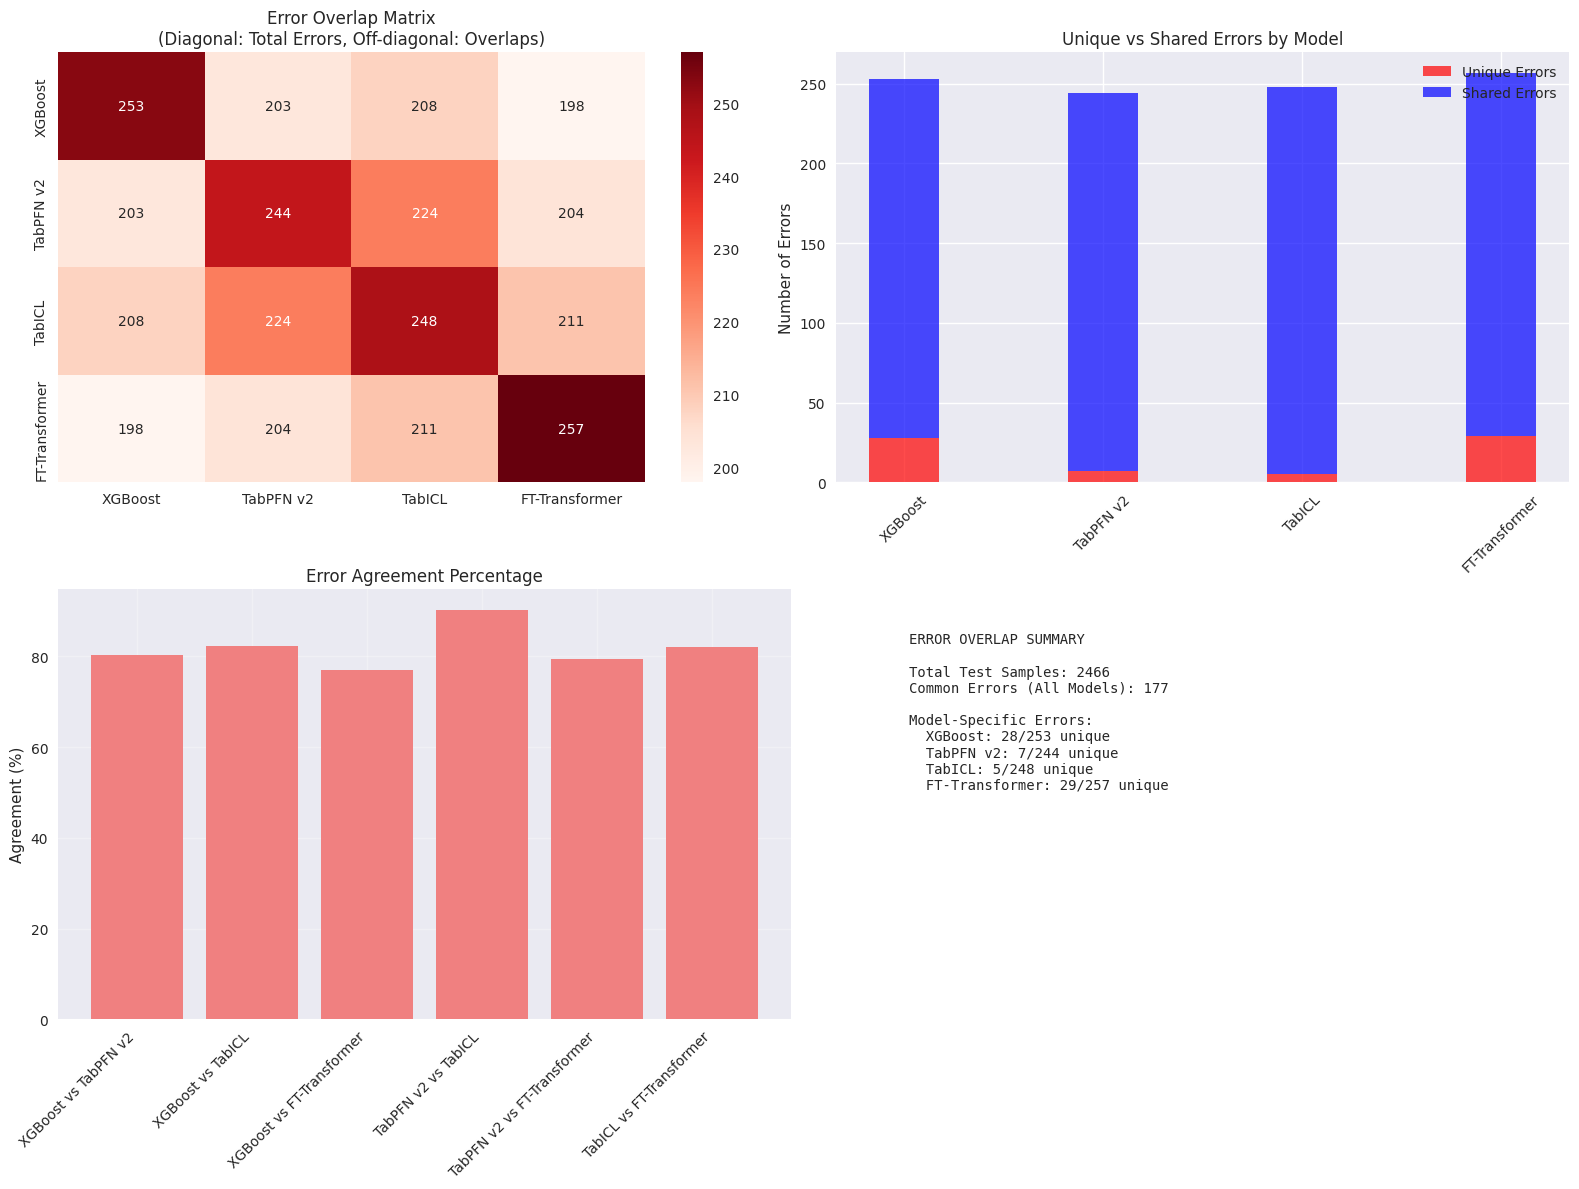

In [16]:
# Visualize error overlap patterns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Error overlap heatmap
overlap_matrix = np.zeros((len(model_names), len(model_names)))
for i in range(len(model_names)):
    for j in range(len(model_names)):
        if i == j:
            overlap_matrix[i, j] = np.sum(error_matrix[:, i])  # Total errors for diagonal
        else:
            overlap_matrix[i, j] = np.sum(error_matrix[:, i] & error_matrix[:, j])  # Overlap

sns.heatmap(overlap_matrix, annot=True, fmt='.0f', cmap='Reds', 
            xticklabels=model_names, yticklabels=model_names, ax=ax1)
ax1.set_title('Error Overlap Matrix\n(Diagonal: Total Errors, Off-diagonal: Overlaps)')

# 2. Unique vs shared errors
unique_errors = [overlap_analysis[f'{model}_unique'] for model in model_names]
total_errors = [np.sum(error_matrix[:, i]) for i in range(len(model_names))]
shared_errors = [total - unique for total, unique in zip(total_errors, unique_errors)]

x = np.arange(len(model_names))
width = 0.35

ax2.bar(x, unique_errors, width, label='Unique Errors', color='red', alpha=0.7)
ax2.bar(x, shared_errors, width, bottom=unique_errors, label='Shared Errors', color='blue', alpha=0.7)
ax2.set_title('Unique vs Shared Errors by Model')
ax2.set_ylabel('Number of Errors')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

# 3. Error agreement percentage
agreement_data = []
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        total_errors_i = np.sum(error_matrix[:, i])
        total_errors_j = np.sum(error_matrix[:, j])
        overlap = np.sum(error_matrix[:, i] & error_matrix[:, j])
        agreement_data.append({
            'model_pair': f'{model_names[i]} vs {model_names[j]}',
            'overlap': overlap,
            'agreement_%': (overlap / max(total_errors_i, total_errors_j)) * 100 if max(total_errors_i, total_errors_j) > 0 else 0
        })

if agreement_data:
    agreement_df = pd.DataFrame(agreement_data)
    ax3.bar(range(len(agreement_data)), agreement_df['agreement_%'], color='lightcoral')
    ax3.set_title('Error Agreement Percentage')
    ax3.set_ylabel('Agreement (%)')
    ax3.set_xticks(range(len(agreement_data)))
    ax3.set_xticklabels(agreement_df['model_pair'], rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)

# 4. Summary statistics
ax4.axis('off')
summary_text = f"""ERROR OVERLAP SUMMARY

Total Test Samples: {len(y_test)}
Common Errors (All Models): {overlap_analysis['common_errors']}

Model-Specific Errors:
"""

for model_name in model_names:
    unique_count = overlap_analysis[f'{model_name}_unique']
    total_count = np.sum(error_matrix[:, model_names.index(model_name)])
    summary_text += f"  {model_name}: {unique_count}/{total_count} unique\n"

ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.savefig('error_overlap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model-Specific Error Insights

Generate detailed insights for TabICL and TabPFN error patterns.

In [17]:
# Generate model-specific error insights
print("🔍 MODEL-SPECIFIC ERROR INSIGHTS")
print("=" * 80)

for model_name in model_names:
    print(f"\n📊 {model_name.upper()} ERROR ANALYSIS")
    print("-" * 60)
    
    # Basic error statistics
    total_errors = len(misclassified_indices[model_name])
    error_rate = total_errors / len(y_test) * 100
    unique_errors = overlap_analysis[f'{model_name}_unique']
    
    print(f"Total Errors: {total_errors} ({error_rate:.2f}%)")
    print(f"Unique Errors: {unique_errors} ({unique_errors/total_errors*100:.1f}% of model errors)")
    
    # Confidence analysis (if available)
    if probabilities[model_name] is not None:
        conf_stats = next((cs for cs in confidence_stats if cs['Model'] == model_name), None)
        if conf_stats:
            print(f"Average Confidence (Correct): {conf_stats['Avg_Confidence_Correct']:.3f}")
            print(f"Average Confidence (Errors): {conf_stats['Avg_Confidence_Misclassified']:.3f}")
            print(f"Low Confidence Errors: {conf_stats['Low_Confidence_Errors_%']:.1f}%")
    
    # Feature analysis
    if feature_error_analysis[model_name] is not None:
        feature_data = feature_error_analysis[model_name]
        significant_features = np.sum(feature_data['significant_features'])
        print(f"Significant Feature Differences: {significant_features}/{len(feature_names)}")
        
        # Top problematic features
        if significant_features > 0:
            sig_indices = np.where(feature_data['significant_features'])[0]
            top_sig = sig_indices[np.argsort(np.abs(feature_data['feature_diff'][sig_indices]))[::-1]][:3]
            print("Top 3 Problematic Features:")
            for i, idx in enumerate(top_sig):
                print(f"  {i+1}. {feature_names[idx]}: {feature_data['feature_diff'][idx]:.4f}")
    
    # Model-specific insights
    if 'TabPFN' in model_name:
        print("\n🧠 TabPFN-Specific Insights:")
        print("  - Prior-based predictions may struggle with out-of-distribution samples")
        print("  - Consider context size optimization for better performance")
        print("  - Errors may indicate dataset shift from pretraining distribution")
    
    elif 'TabICL' in model_name:
        print("\n🎯 TabICL-Specific Insights:")
        print("  - In-context learning errors may indicate poor example selection")
        print("  - Consider diverse example selection strategies")
        print("  - Context window utilization may need optimization")
    
    elif 'XGBoost' in model_name:
        print("\n🌳 XGBoost-Specific Insights:")
        print("  - Tree-based errors often indicate feature interaction issues")
        print("  - Consider feature engineering or hyperparameter tuning")
        print("  - May benefit from ensemble methods")

🔍 MODEL-SPECIFIC ERROR INSIGHTS

📊 XGBOOST ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 253 (10.26%)
Unique Errors: 28 (11.1% of model errors)
Average Confidence (Correct): 0.940
Average Confidence (Errors): 0.767
Low Confidence Errors: 17.0%
Significant Feature Differences: 11/17
Top 3 Problematic Features:
  1. ProductRelated: 0.6888
  2. ProductRelated_Duration: 0.6073
  3. Administrative: 0.5784

🌳 XGBoost-Specific Insights:
  - Tree-based errors often indicate feature interaction issues
  - Consider feature engineering or hyperparameter tuning
  - May benefit from ensemble methods

📊 TABPFN V2 ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 244 (9.89%)
Unique Errors: 7 (2.9% of model errors)
Average Confidence (Correct): 0.936
Average Confidence (Errors): 0.737
Low Confidence Errors: 27.5%
Significant Feature Differences: 11/17
Top 3 Problematic Features:
  1. ProductRelated: 0.5894
  2. PageVal

## 6. Summary and Recommendations

Comprehensive summary of error analysis findings and actionable recommendations.

In [18]:
# Generate comprehensive summary and recommendations
print("📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY")
print("=" * 80)

# Overall performance ranking
error_rates = [(model, len(misclassified_indices[model])/len(y_test)*100) for model in model_names]
error_rates.sort(key=lambda x: x[1])

print("\n🏆 PERFORMANCE RANKING (by error rate):")
for i, (model, rate) in enumerate(error_rates):
    print(f"   {i+1}. {model}: {rate:.2f}% error rate")

# Key findings
print("\n🔍 KEY FINDINGS:")
print(f"   • Best performing model: {error_rates[0][0]} ({error_rates[0][1]:.2f}% error rate)")
print(f"   • Common errors across all models: {overlap_analysis['common_errors']} samples")
print(f"   • Most unique errors: {max(model_names, key=lambda m: overlap_analysis[f'{m}_unique'])}")

if confidence_stats:
    most_confident = max(confidence_stats, key=lambda x: x['Avg_Confidence_Correct'])
    print(f"   • Most confident model: {most_confident['Model']} ({most_confident['Avg_Confidence_Correct']:.3f} avg confidence)")

# Recommendations
print("\n💡 RECOMMENDATIONS:")

print("\n1. Model Selection:")
print(f"   • For production: {error_rates[0][0]} (lowest error rate)")
if confidence_stats:
    most_reliable = min(confidence_stats, key=lambda x: abs(x['Avg_Confidence_Correct'] - x['Avg_Confidence_Misclassified']))
    print(f"   • For reliability: {most_reliable['Model']} (most consistent confidence)")

print("\n2. Error Reduction Strategies:")
for model_name in model_names:
    unique_count = overlap_analysis[f'{model_name}_unique']
    if unique_count > 0:
        print(f"   • {model_name}: Focus on {unique_count} unique error cases")
        
        if feature_error_analysis[model_name] is not None:
            sig_features = np.sum(feature_error_analysis[model_name]['significant_features'])
            if sig_features > 0:
                print(f"     - Address {sig_features} problematic features")

print("\n3. Ensemble Opportunities:")
print(f"   • Models show complementary errors (only {overlap_analysis['common_errors']} common errors)")
print("   • Consider ensemble methods to leverage model diversity")
print("   • Weighted voting based on confidence scores could improve performance")

print("\n4. Data Quality Improvements:")
if overlap_analysis['common_errors'] > 0:
    print(f"   • Investigate {overlap_analysis['common_errors']} samples misclassified by all models")
    print("   • These may indicate data quality issues or inherently difficult cases")
    print("   • Consider data cleaning or feature engineering for these samples")

print("\n5. Model-Specific Improvements:")
for model_name in model_names:
    if 'TabPFN' in model_name:
        print(f"   • {model_name}: Optimize context size and check for distribution shift")
    elif 'TabICL' in model_name:
        print(f"   • {model_name}: Improve example selection and context utilization")
    elif 'XGBoost' in model_name:
        print(f"   • {model_name}: Feature engineering and hyperparameter optimization")

print("\n✅ Error analysis complete! Use these insights to improve model performance.")

📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY

🏆 PERFORMANCE RANKING (by error rate):
   1. TabPFN v2: 9.89% error rate
   2. TabICL: 10.06% error rate
   3. XGBoost: 10.26% error rate
   4. FT-Transformer: 10.42% error rate

🔍 KEY FINDINGS:
   • Best performing model: TabPFN v2 (9.89% error rate)
   • Common errors across all models: 177 samples
   • Most unique errors: FT-Transformer
   • Most confident model: XGBoost (0.940 avg confidence)

💡 RECOMMENDATIONS:

1. Model Selection:
   • For production: TabPFN v2 (lowest error rate)
   • For reliability: XGBoost (most consistent confidence)

2. Error Reduction Strategies:
   • XGBoost: Focus on 28 unique error cases
     - Address 11 problematic features
   • TabPFN v2: Focus on 7 unique error cases
     - Address 11 problematic features
   • TabICL: Focus on 5 unique error cases
     - Address 12 problematic features
   • FT-Transformer: Focus on 29 unique error cases
     - Address 12 problematic features

3. Ensemble Opportunities:
   • Mo